<a href="https://colab.research.google.com/github/Malware-Analysis-Using-Grad-CAM/Project/blob/master/MalwareDetectFromCuckoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import random
import os
from torchtext.data import Field, LabelField, TabularDataset, Dataset, BucketIterator



In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:

class ClassifierWithAttention(nn.Module):
    def __init__(self, batch_size, vocab_size, embed_size, hidden_size, output_size):
        super(ClassifierWithAttention, self).__init__()

        '''
        batch_size: size of the batch
        vocab_size: size of vocabulary containing api name
        embed_size: Embedding dimension
        hidden_size: size of the hidden state of the LSTM
        output_size: 2 = (benign, malware)

        embedding: layer for embedding
        LSTM: LSTM layer
        out: fully connected layer
        act: sigmoid activation function
        '''
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(self.vocab_size, self.embed_size)
        self.lstm = nn.LSTM(
            self.embed_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.act = nn.Sigmoid()

    def attention_net(self, lstm_output, final_state):
        '''
        lstm_output: (batch_size, num_seq, hidden_size)
        hidden: (batch_size, hidden_size, 1)

        compute attention weight by batch matrix multiplication of lstm_output and hidden
        attn_weight: (batch_size, num_seq)
        attn_applied: (batch_size, hidden_size)
        
        '''
        hidden = final_state.view(-1, self.hidden_size, 1)
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2)
        attn_weights = F.softmax(attn_weights, 1)
        attn_applied = torch.bmm(
            lstm_output.transpose(1, 2), attn_weights.unsqueeze(2)
        ).squeeze(2)
        return attn_applied, attn_weights

    def forward(self, input):
        '''
        parameter
        input: tensor shape of number of sequence of API ID

        returns
        output: output of one-hot encoded vector.
        output.shape == self.output_size (normally 2 for benign and malware)
        attn_weight: attention weights
        '''
        embedded = self.embedding(input) # embedding input
        embedded = embedded.permute(1, 0, 2) # (batch_size, num_seq, hidden_size) -> (num_seq, batch_size, hidden_size)

        # initialize hidden state and cell
        h_0 = torch.zeros(1, len(input), self.hidden_size).cuda()
        c_0 = torch.zeros(1, len(input), self.hidden_size).cuda()

        lstm_output, (hidden, cell) = self.lstm(embedded, (h_0, c_0))
        lstm_output = lstm_output.permute(1, 0, 2) # (num_seq, batch_size, hidden_size) -> (batch_size, num_seq, hidden_size)

        attn_applied, attn_weights = self.attention_net(lstm_output, hidden) # apply attention

        output = self.out(attn_applied)
        output = output.squeeze()
        output = self.act(output)

        return output, attn_weights

    def initHidden(self):
        return torch.zroes(1, 1, self.hidden_size, device=device)


In [6]:
def move_to(l):
    # move tensors to device
    return [i.to(device) for i in l]


def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    num_corrects = 0

    model.train()

    for batch in iterator:
        optimizer.zero_grad()

        api, api_length = batch.api

        output, attn = model(api)
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if len(batch) == 1:
          output = output.unsqueeze(0)
        loss = criterion(output, target)
        num_corrects = (torch.max(output, 1)[1].view(
            target.size()).data == target.data).sum()

        acc = torch.true_divide(num_corrects, len(batch))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [7]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for batch in iterator:
            api, api_length = batch.api

            predictions, attn = model(api)
            predictions = predictions.squeeze()

            target = batch.label
            target = torch.autograd.Variable(target).long()

            if len(batch) == 1:
              predictions = predictions.unsqueeze(0)
            loss = criterion(predictions, target)
            num_corrects = (torch.max(predictions, 1)[1].view(
                target.size()).data == target.data).sum()
            acc = torch.true_divide(num_corrects, len(batch))

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [9]:
import sys
import csv

maxInt = sys.maxsize
while True:
  try:
    csv.field_size_limit(maxInt)
    break
  except OverflowError:
    maxInt //= 2

API = Field(
    sequential=True,
    lower=False,
    include_lengths=True,
    batch_first=True,
)
LABEL = LabelField()

fields = [('api', API), ('label', LABEL)]

data = TabularDataset(
    path="/content/gdrive/My Drive/data/results.csv",
    format="csv",
    fields=fields,
    skip_header=True
)
train_data, valid_data = data.split(split_ratio=0.7)

API.build_vocab(train_data, max_size=1000)
LABEL.build_vocab(train_data)

BATCH_SIZE = 1

train_loader, valid_loader = BucketIterator.splits(
    (train_data, valid_data),
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.api),
    device = device,
)

num_id = len(API.vocab)
embedding_size = 300
num_hidden_nodes = 16
num_output_nodes = 2

model = ClassifierWithAttention(
    BATCH_SIZE, num_id, embedding_size, num_hidden_nodes, num_output_nodes)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

for epoch in range(5):
  train_loss, train_acc = train(model, train_loader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

  print("epoch {}".format(epoch))
  print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
  print(f"\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%")


['GetSystemTimeAsFileTime', 'SetUnhandledExceptionFilter', 'SetErrorMode', 'GetFileAttributesW', 'GetFileAttributesW', 'CreateActCtxW', 'CreateActCtxW', 'CreateActCtxW', 'CreateActCtxW', 'NtClose', 'LdrLoadDll', 'NtCreateFile', 'NtReadFile', 'SetFilePointer', 'NtReadFile', 'NtClose', 'NtCreateFile', 'NtCreateSection', 'NtMapViewOfSection', 'NtClose', 'NtOpenKey', 'NtQueryValueKey', 'NtClose', 'LoadStringW', 'LoadStringW', 'LdrGetDllHandle', 'LdrGetProcedureAddress', 'LdrGetDllHandle', 'LdrGetProcedureAddress', 'LdrGetDllHandle', 'LdrGetProcedureAddress', 'LdrGetProcedureAddress', 'MessageBoxTimeoutW', 'NtTerminateProcess', 'NtTerminateProcess', 'NtClose', 'NtClose', 'NtClose', 'NtClose', 'LdrGetDllHandle', 'LdrGetProcedureAddress', 'LdrGetDllHandle', 'LdrGetProcedureAddress', 'NtFreeVirtualMemory', 'NtClose', 'NtClose', 'NtClose', 'NtClose', 'NtClose', 'NtClose', 'NtClose', 'NtClose', 'NtClose', 'NtClose', 'NtClose', 'NtClose', 'NtClose', 'NtClose', 'NtClose', 'NtClose', 'NtClose', 'Ld

In [17]:
def predict(model, api_sequence):
  tokenized = API.preprocess(api_sequence)
  indexed = [API.vocab.stoi[t] for t in tokenized]
  tensor = torch.LongTensor(indexed).to(device)
  tensor = tensor.unsqueeze(1).T
  out, atten_weights = model(tensor)
  out = F.softmax(out, 0)
  prediction = LABEL.vocab.itos[torch.argmax(out)]
  return prediction, atten_weights, tokenized
  

<BarContainer object of 66 artists>

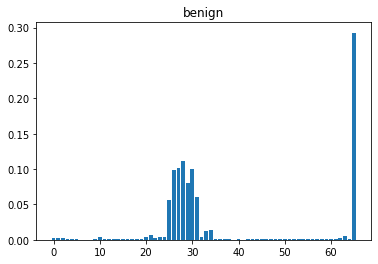

In [26]:
import matplotlib.pyplot as plt

model.eval()

# predict: predicted vector
# attn: attention weight vector

benign_api = "GetSystemTimeAsFileTime SetUnhandledExceptionFilter SetErrorMode GetFileAttributesW GetFileAttributesW CreateActCtxW CreateActCtxW CreateActCtxW CreateActCtxW NtClose LdrLoadDll NtCreateFile NtReadFile SetFilePointer NtReadFile NtClose NtCreateFile NtCreateSection NtMapViewOfSection NtClose NtOpenKey NtQueryValueKey NtClose LoadStringW LoadStringW LdrGetDllHandle LdrGetProcedureAddress LdrGetDllHandle LdrGetProcedureAddress LdrGetDllHandle LdrGetProcedureAddress LdrGetProcedureAddress MessageBoxTimeoutW NtTerminateProcess NtTerminateProcess NtClose NtClose NtClose NtClose LdrGetDllHandle LdrGetProcedureAddress LdrGetDllHandle LdrGetProcedureAddress NtFreeVirtualMemory NtClose NtClose NtClose NtClose NtClose NtClose NtClose NtClose NtClose NtClose NtClose NtClose NtClose NtClose NtClose NtClose NtClose LdrUnloadDll NtOpenKey NtQueryValueKey NtClose NtTerminateProcess "
prediction, attn, tokenized = predict(model, benign_api)
attn = attn.cpu().detach().numpy().squeeze()

# attention visualization

# attention on api sequence
plt.title(prediction)
plt.bar(np.arange(len(attn)), attn)


<BarContainer object of 66 artists>

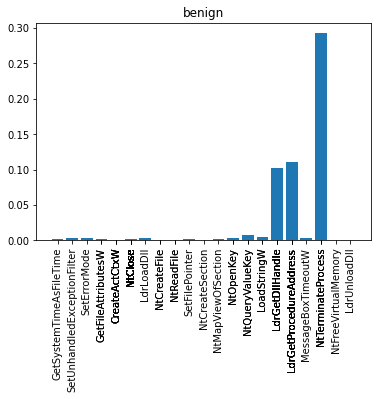

In [27]:
# attention visualization by api names
plt.title(prediction)
plt.xticks(rotation=90)
plt.bar(tokenized, attn, tick_label=tokenized)

<BarContainer object of 10 artists>

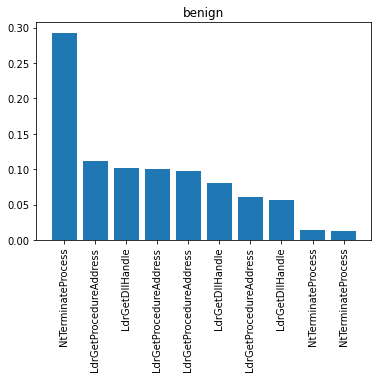

In [28]:
sort_arg = attn.argsort()
sort_arg = sort_arg[::-1]
sorted_attn = attn[sort_arg]
sorted_api_name = np.array(tokenized)[sort_arg]

plt.title(prediction)
plt.xticks(rotation=90)
# top 10 attentions on api calls
plt.bar(np.arange(len(sorted_attn[:10])), sorted_attn[:10], tick_label=sorted_api_name[:10])



<BarContainer object of 408 artists>

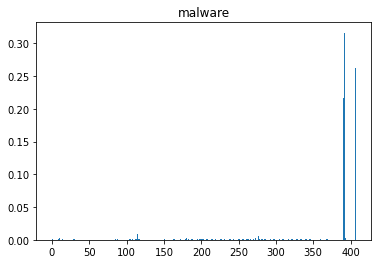

In [29]:
malware_api = "NtCreateFile GetFileSize NtCreateSection NtMapViewOfSection NtAllocateVirtualMemory NtUnmapViewOfSection NtClose NtClose GetSystemDirectoryA GetSystemDirectoryA LdrLoadDll LdrGetProcedureAddress LdrGetProcedureAddress LdrGetProcedureAddress NtOpenKey NtOpenKey NtQueryValueKey NtClose NtOpenKey NtOpenKey NtOpenKey NtOpenKey NtOpenKey NtOpenKey NtOpenKey NtOpenKey NtOpenKey NtOpenKey NtOpenKey NtOpenKey NtOpenKey NtOpenKey NtOpenKey NtClose NtOpenKey NtClose NtOpenKey NtClose NtOpenKey NtClose NtOpenKey NtClose NtOpenKey NtClose NtOpenKey NtClose NtOpenKey NtClose NtOpenKey NtClose NtOpenKey NtClose NtOpenKey NtClose NtOpenKey NtClose NtOpenKey NtClose NtOpenKey NtClose NtOpenKey NtClose NtOpenKey NtOpenKey NtQueryValueKey NtClose NtOpenKey NtQueryValueKey NtClose NtClose NtOpenKey NtClose NtOpenKey GetSystemTimeAsFileTime NtOpenKey NtQueryValueKey NtClose NtClose NtClose NtOpenKey NtQueryValueKey NtClose NtCreateFile NtClose GetVolumePathNameW NtQueryInformationFile SetErrorMode GetFileAttributesW FindFirstFileExW NtClose FindFirstFileExW NtClose FindFirstFileExW NtClose FindFirstFileExW NtClose FindFirstFileExW NtClose SetErrorMode GetSystemTimeAsFileTime RegOpenKeyExA RegQueryValueExA RegCloseKey GetSystemDirectoryW NtCreateMutant NtCreateMutant RegOpenKeyExA LdrLoadDll LdrGetProcedureAddress SetFilePointer NtReadFile GetSystemInfo NtAllocateVirtualMemory NtFreeVirtualMemory NtAllocateVirtualMemory LdrLoadDll LdrGetProcedureAddress GetSystemInfo GetFileSize NtCreateSection NtMapViewOfSection NtMapViewOfSection NtUnmapViewOfSection NtUnmapViewOfSection NtClose GetSystemTimeAsFileTime RegOpenKeyExW RegQueryValueExW RegQueryValueExW RegCloseKey RegOpenKeyExW RegQueryValueExW RegQueryValueExW RegCloseKey RegOpenKeyExW RegQueryValueExW RegQueryValueExW RegCloseKey RegOpenKeyExW RegQueryValueExW RegQueryValueExW RegCloseKey RegOpenKeyExW RegQueryValueExW RegQueryValueExW RegCloseKey RegOpenKeyExW RegQueryValueExW RegQueryValueExW RegCloseKey RegOpenKeyExW RegOpenKeyExW RegQueryValueExW RegQueryValueExW RegCloseKey LdrGetProcedureAddress LdrGetProcedureAddress LdrGetProcedureAddress LdrGetProcedureAddress LdrGetProcedureAddress LdrGetProcedureAddress LdrGetProcedureAddress LdrLoadDll LdrGetProcedureAddress CryptAcquireContextA NtClose RegOpenKeyExW RegCreateKeyExW RegCloseKey RegQueryValueExW RegCloseKey NtClose RegOpenKeyExW RegOpenKeyExW RegCloseKey RegQueryValueExW RegCloseKey RegOpenKeyExW NtClose RegOpenKeyExW RegOpenKeyExW RegCloseKey RegOpenKeyExW RegOpenKeyExW RegQueryValueExW RegQueryValueExW RegCloseKey RegOpenKeyExW GetFileSize RegOpenKeyExW NtCreateSection NtMapViewOfSection NtUnmapViewOfSection NtClose RegOpenKeyExA RegEnumKeyExA RegOpenKeyExA RegOpenKeyExA RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegCloseKey RegCloseKey RegEnumKeyExA RegOpenKeyExA RegOpenKeyExA RegCloseKey RegEnumKeyExA RegCloseKey LdrLoadDll LdrGetProcedureAddress LdrGetProcedureAddress LdrLoadDll CreateThread RegOpenKeyExA RegEnumKeyExA RegOpenKeyExA RegOpenKeyExA RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegOpenKeyExA RegQueryInfoKeyW RegEnumValueW RegEnumValueW RegCloseKey RegEnumKeyExA RegCloseKey RegCloseKey RegEnumKeyExA RegOpenKeyExA RegOpenKeyExA RegCloseKey RegEnumKeyExA RegCloseKey LdrGetProcedureAddress SetFilePointer LdrGetProcedureAddress GetFileSize NtCreateSection NtMapViewOfSection NtUnmapViewOfSection NtClose LdrGetProcedureAddress NtClose NtAllocateVirtualMemory NtAllocateVirtualMemory NtOpenKey NtQueryValueKey NtClose NtOpenKey NtClose NtClose LdrUnloadDll FindResourceA LoadResource SizeofResource FindResourceA LoadResource SizeofResource LoadStringW LoadStringW MessageBoxTimeoutW NtFreeVirtualMemory NtClose NtClose NtUnmapViewOfSection NtClose CoUninitialize NtTerminateProcess NtTerminateProcess NtClose NtUnmapViewOfSection NtClose NtClose NtClose NtClose NtClose LdrUnloadDll NtOpenKey NtQueryValueKey NtClose NtClose NtFreeVirtualMemory NtClose NtTerminateProcess "
prediction, attn, tokenized = predict(model, malware_api)
attn = attn.cpu().detach().numpy().squeeze()

# attention visualization

# attention on api sequence
plt.title(prediction)
plt.bar(np.arange(len(attn)), attn)


<BarContainer object of 408 artists>

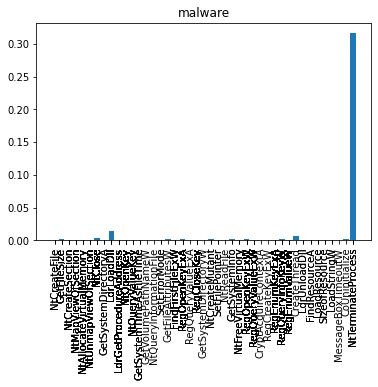

In [30]:
# attention visualization by api names
plt.title(prediction)
plt.xticks(rotation=90)
plt.bar(tokenized, attn, tick_label=tokenized)

<BarContainer object of 10 artists>

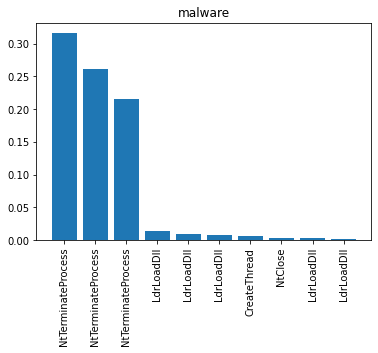

In [31]:
sort_arg = attn.argsort()
sort_arg = sort_arg[::-1]
sorted_attn = attn[sort_arg]
sorted_api_name = np.array(tokenized)[sort_arg]

plt.title(prediction)
plt.xticks(rotation=90)
# top 10 attentions on api calls
plt.bar(np.arange(len(sorted_attn[:10])), sorted_attn[:10], tick_label=sorted_api_name[:10])